# ASE2020 submission id #302 -- iCPD

20-04-2020 XXXXXXXXXXX


In [28]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(7)

## 1. Now, the first step is to generate some runtime data

 In the sensor model of UNDERSEA, because:
 1. The transition of interest is from state 1 to 2 and that is the only out going transition from state 1
 2. Other transitions are all *instantaneous* whose holding time can be ignored.
 
 So we can simplify our simulation to generate some runtime data in the following way.

In [29]:
expected_w_time=600 #the window size in seconds 
expected_cp_time = 300 # the ground truth change point index in that window


the_a = 6.0 # the ground truth transition rate before cp
the_num_tran_before_cp=int(expected_cp_time*the_a)
data_before_cp = np.random.exponential(1/the_a, the_num_tran_before_cp)

#print(sum(data_before_cp),np.mean(data_before_cp),len(data_before_cp),the_num_tran_before_cp)

the_b = 2.0 # the ground truth transition rate after cp
the_num_tran_after_cp=int(the_b*(expected_w_time-expected_cp_time))
data_after_cp = np.random.exponential(1/the_b, the_num_tran_after_cp)

#print(sum(data_after_cp),np.mean(data_after_cp),len(data_after_cp),the_num_tran_after_cp)

raw_data=np.append(data_before_cp,data_after_cp)
#print(np.sum(raw_data[0:the_num_tran_before_cp]),
      #sum(raw_data[the_num_tran_before_cp:the_num_tran_before_cp+the_num_tran_after_cp]),
      #sum(raw_data),len(raw_data))
        
the_cp_time=sum(data_before_cp)
w_time=sum(raw_data)

w=len(raw_data)
the_cp=len(data_before_cp)

print('the ground truth change point time is {0}'.format(the_cp_time))
print('the ground truth time window is {0}'.format(w_time))
print('number of transitions before cp {0}'.format(the_cp))
print('total number of transitions {0}'.format(w))

the ground truth change point time is 293.1545645193046
the ground truth time window is 585.1210888394587
number of transitions before cp 1800
total number of transitions 2400


In [30]:
data=np.cumsum(raw_data) #reshape the data by accumulated sum
print(data)

[1.32294849e-02 2.65522597e-01 3.61686241e-01 ... 5.84888948e+02
 5.85047102e+02 5.85121089e+02]


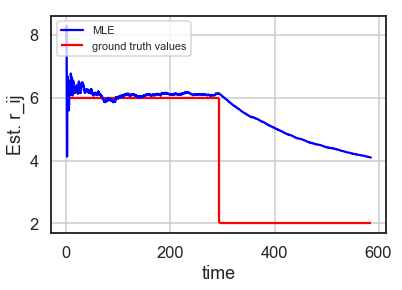

In [31]:
# first, let us play with a MLE estimator..
r_MLE=np.array([])
i=1
while i<=len(data) :
    r_MLE=np.append(r_MLE,i/data[i-1])
    i=i+1

plt.plot(data[1:],r_MLE[1:],linestyle='-',color='b',label='MLE')

plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('time')
plt.ylabel('Est. r_ij')
plt.grid(True)

plt.show()

## 2. Use IPSP to estimate the $p_{ij}$ given the simulated data

In [32]:
# this is the IPSP estimator
def IPSP_est_pij(ti, nij, c_prior_lower, c_prior_upper, rij_prior_lower, rij_prior_upper):
#define function to use sets of priors to update transition probabilityes r_ij 
#the t_i is the totoal holding time in state i
#the n_ij is the number of transtions from i to j.
#the other 4 parameters are defining the set of priors of IPSP
    rij_post_lower=0
    rij_post_upper=0

    if(ti==0):
        return rij_prior_lower, rij_prior_upper
    if(nij/ti) >= rij_prior_lower:
        rij_post_lower=(c_prior_upper*rij_prior_lower+nij)/(c_prior_upper+ti)
        
    if(nij/ti) < rij_prior_lower:
        rij_post_lower=(c_prior_lower*rij_prior_lower+nij)/(c_prior_lower+ti)
        
    if (nij/ti) <= rij_prior_upper:
        rij_post_upper=(c_prior_upper*rij_prior_upper+nij)/(c_prior_upper+ti)
        
    if (nij/ti) > rij_prior_upper:
        rij_post_upper=(c_prior_lower*rij_prior_upper+nij)/(c_prior_lower+ti)
        

    return rij_post_lower, rij_post_upper

In [34]:
IPSP_est_upper=[]
IPSP_est_lower=[]
IPSP_est_diff=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
t_prior_lower=200
t_prior_upper=400
rij_prior_lower=5.5
rij_prior_upper=6.5

timer=0
while timer<=w_time:
    temp_index=0
    temp_index = np.argmax(data>= timer)# the index of the array that bigger than timer..
    
    temp_lower, temp_upper=IPSP_est_pij(timer,temp_index,
                                        t_prior_lower,t_prior_upper,
                                        rij_prior_lower,rij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower.append(temp_lower)
    IPSP_est_upper.append(temp_upper)
    IPSP_est_diff.append(temp_upper-temp_lower)
    
    timer=timer+1# every 1 seconds invoke a IPSP estimation
    
print(len(IPSP_est_diff))

586


In [35]:
int(w_time)

585

range(0, 586)


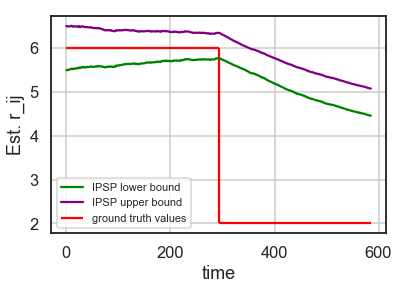

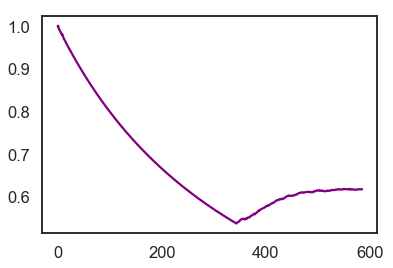

In [36]:

x_index = range(0,int(w_time)+1,1)#only for aiding the plots...

print(x_index)
plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(x_index,IPSP_est_lower,linestyle='-',color='green',label='IPSP lower bound')
plt.plot(x_index,IPSP_est_upper,linestyle='-',color='purple',label='IPSP upper bound')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=11)
plt.xlabel('time')
plt.ylabel('Est. r_ij')
plt.grid(True)

plt.show()

plt.plot(x_index,IPSP_est_diff,linestyle='-',color='purple',label='IPSP bound width')
plt.show()

## 3. The trigger of CPD

(XZ: Not sure if it is making sense. We can discuss later. I am using a very naive trigger)

In [37]:

the_tp_time=0# the trigger point
timer=0#the trigger point only
while timer<w_time:
    # and ignore the first x seconds (e.g., 100 seconds)
    if timer>150 and IPSP_est_diff[timer]-IPSP_est_diff[timer-1]>0:
        the_tp_time=timer
        break
    timer=timer+1

In [38]:
#now the window of the data is from 0 to the_tp
if the_tp_time==0:
    print('no CPD analysis is triggered')
else:
    #print('the tirgier point is at {0} index'.format(the_tp))
    print('the tirgier point is at {0}s time'.format(the_tp_time))
    the_tp_index=np.argmax(data>= the_tp_time)
    print('the tirgier point index is at {0}'.format(the_tp_index))
    

the tirgier point is at 345s time
the tirgier point index is at 1891


## 4. The CPD analysis

Now let us define our likelihood function

In [39]:
# note the x arguments in the functions below are time 

def N(x):
    # return the number of transitions before the x point 
    # and only use data up to the trigger point..
    return np.argmax(data[0:the_tp_index]>= x)
     
def M(x):
    # return the number of transitions after the x point 
    # and only use data up to the trigger point..
    return len(data[0:the_tp_index])-np.argmax(data>= x)

def log_likelihood(x):
    # simply the exponentional likelihood, I am using log now..
    a=(N(x)/x) #x!=0
    b=(M(x)/(the_tp_time-x))# note, here w!=x..
    #print(a,b,N(x),M(x))
    #return np.exp(N(x)*math.log(N(x))+M(x)*math.log(M(x))-math.log(math.factorial(N(x)))-math.log(math.factorial(M(x)))-N(x)-M(x))
    #return sp.stats.poisson.pmf(N(x),N(x))*sp.stats.poisson.pmf(M(x),M(x))
    return -a*x+N(x)*math.log(a)-b*(the_tp_time-x)+M(x)*math.log(b)

    

print((log_likelihood(100)))
print(log_likelihood(290))

1329.5868883066057
1412.3585674751937


Now let us do MCMC samplings...

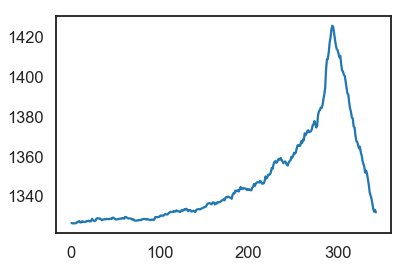

In [40]:

#this code is to visualise the likelihood
def h(b):
    l = []
    for i in b:
        l.append((log_likelihood(i)))
    return l
t = np.arange(1, the_tp_time-1, 1)
plt.plot(t, h(t))
plt.show()


In [162]:
x_current = the_tp_time/2 #starting point of MCMC
x_posterior=[x_current] 
samples=15000 # number of samples
std=2#the std of the proposal dist. which needs to be fine tuned
test=[1]

for i in range(samples):
    # step 1: from a symetrical normal dist., sample a proposed x 
    
    proposal = np.random.normal(x_current, std, 1) 
    
    while proposal[0]<=1 or proposal[0]>=the_tp_time-1: #the proposal x cannot 0 or the trigger point
        proposal = np.random.normal(x_current, std, 1)

    proposal=proposal[0]
    #print(proposal)
    #step 2: let us decide if we accpet that proposal or not.
    log_likelihood_current =log_likelihood(x_current)
    log_likelihood_proposal =log_likelihood(proposal)

    # Compute prior probability of current and proposed x        
    prior_current = 1/the_tp_time #here we assume prior x is unifomly distributed, but you can use others\\
    prior_proposal = 1/the_tp_time # for sure, then you change here..

    # Nominator of Bayes formula
    #p_current = likelihood_current #* prior_current
    #p_proposal = likelihood_proposal #* prior_proposal

    p_accept = np.exp(log_likelihood_proposal-log_likelihood_current)#p_accept = p_proposal / p_current
    #print(p_accept)

    accept = np.random.rand() < p_accept
    test.append(accept) # record the number of proposals being accpeted for fine tune.

    # if accpet then change the x_current and put the accpected sample in to posterior

    if accept:
    # Update position
        x_current = proposal
        x_posterior.append(x_current)



Text(168.92641976725687, 0.09, 'Variance=405.221012')

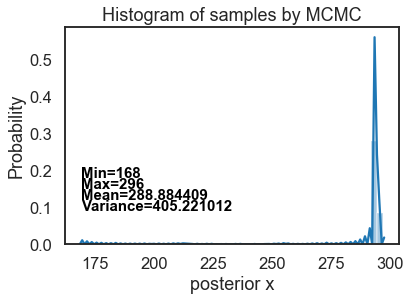

In [163]:
ax = plt.subplot()
sns.distplot(x_posterior, ax=ax, kde=True, hist=True)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior x', ylabel='Probability');

ax.text(min(x_posterior),0.18,'Min=%d'%min(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.15,'Max=%d'%max(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.12,'Mean=%f'%sp.mean(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.09,'Variance=%f'%sp.var(x_posterior),size=15, color='black', weight='semibold')


In [164]:
print(sum(test)/samples)# tune the std in the MCMC, good range is 0.2-0.5
print(sum(test))

0.24666666666666667
3700


In [165]:
# correspondingly the posterior for b is
def calulate_b_post(x_post):
    b_post = []
    for i in x_post:
        b_post.append((M(i))/(the_tp_time-i))
    return b_post

b_posterior=calulate_b_post(x_posterior)

Text(1.7125257378886038, 9, 'Variance=0.412794')

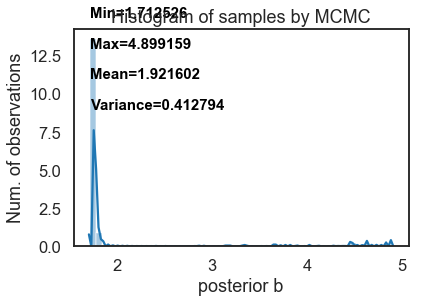

In [166]:

ax = plt.subplot()

sns.distplot(b_posterior, ax=ax, kde=True, hist=True)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior b', ylabel='Num. of observations');

ax.text(min(b_posterior),15,'Min=%f'%min(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),13,'Max=%f'%max(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),11,'Mean=%f'%sp.mean(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),9,'Variance=%f'%sp.var(b_posterior),size=15, color='black', weight='semibold')

Now do some statistics on the two posterior distributions

In [167]:
print(sp.stats.describe(x_posterior))
print(sp.stats.describe(b_posterior))

DescribeResult(nobs=3700, minmax=(168.92641976725687, 296.998738269574), mean=288.88440936635857, variance=405.3305604508933, skewness=-4.232377264445451, kurtosis=17.28858784543738)
DescribeResult(nobs=3700, minmax=(1.7125257378886038, 4.899159300004738), mean=1.9216020056049097, variance=0.41290579512699294, skewness=3.605800758354141, kurtosis=11.533139610972354)


## 5. The new IPSP+CPD run time estimates on $p_{ij}$.

First, based on the CPD analysis, we use the mean of the posterior distribution of x as the estimated change point.

In [168]:
est_x=(np.mean(x_posterior))# this is time
est_x_index=np.argmax(data>= est_x)
print(est_x,est_x_index)

288.88440936635857 1769


Now, before the change point, the IPSP estimates are:

In [169]:
IPSP_est_upper_before_cp=[]
IPSP_est_lower_before_cp=[]
IPSP_est_diff_before_cp=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
t_prior_lower=200
t_prior_upper=400
rij_prior_lower=5.5
rij_prior_upper=6.5

timer=0
while timer<=est_x:#before the cp
    
    temp_index=0
    temp_index = np.argmax(data>= timer)# the index of the array that bigger than timer..
    
    temp_lower, temp_upper=IPSP_est_pij(timer,temp_index,
                                        t_prior_lower,t_prior_upper,
                                        rij_prior_lower,rij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower_before_cp.append(temp_lower)
    IPSP_est_upper_before_cp.append(temp_upper)
    IPSP_est_diff_before_cp.append(temp_upper-temp_lower)
    
    timer=timer+1# every 1 seconds invoke a IPSP estimation

While, after the estimated change point:
(Note, the way we construct the new set of priors for IPSP after the change point is:
1. the min and max of b posterior distribution are the prior lower and upper for mean $p_{ij}$.  Actually, I feel, to be conservative, we may want to make the initial bounds a bit wider..
2. Since the prior mean bounds are obtained from the number of trials from the change point the trigger point, so the lower and upper prior confidence parameter should be the_tp-max(x_posterior) and the_tp-min(x_posterior) respectively.

In [176]:
IPSP_est_upper_after_cp=[]
IPSP_est_lower_after_cp=[]
IPSP_est_diff_after_cp=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
t_prior_lower=the_tp_time-max(x_posterior)
t_prior_upper=the_tp_time-min(x_posterior)
rij_prior_lower=1*np.min(b_posterior)
rij_prior_upper=1*np.quantile(b_posterior,0.93)
# we could make the intial bounds wider or narrower if we see outliers
# in this case, there *are* outliers, so we use a 92% quantile 

print(t_prior_lower,t_prior_upper,rij_prior_lower,rij_prior_upper)

timer=est_x
while timer<=w_time: #from the cp to the end of data window
    
    temp_index=0
    temp_index = np.argmax(data>= timer)# the index of the array that bigger than timer..
    temp_index=temp_index-est_x_index
    
    temp_lower, temp_upper=IPSP_est_pij(timer-est_x,temp_index,
                                        t_prior_lower,t_prior_upper,
                                        rij_prior_lower,rij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower_after_cp.append(temp_lower)
    IPSP_est_upper_after_cp.append(temp_upper)
    IPSP_est_diff_after_cp.append(temp_upper-temp_lower)
    
    timer=timer+1# every 1 seconds invoke a IPSP estimation

48.001261730425995 176.07358023274313 1.7125257378886038 2.8493755224175183


In [177]:
new_IPSP_est_upper=np.append(IPSP_est_upper_before_cp,IPSP_est_upper_after_cp)
new_IPSP_est_lower=np.append(IPSP_est_lower_before_cp,IPSP_est_lower_after_cp)
new_IPSP_est_diff=np.append(IPSP_est_diff_before_cp,IPSP_est_diff_after_cp)

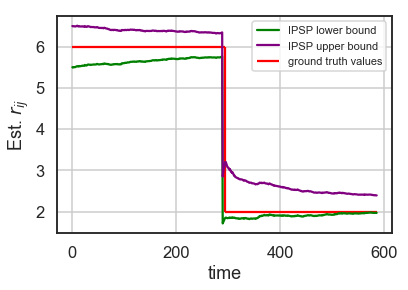

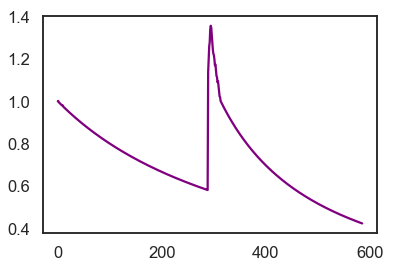

In [178]:
x_index = range(0,math.ceil(w_time),1)#only for aiding the plots...

plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(x_index,new_IPSP_est_lower[:],linestyle='-',color='green',label='IPSP lower bound')
plt.plot(x_index,new_IPSP_est_upper[:],linestyle='-',color='purple',label='IPSP upper bound')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=11)
plt.xlabel('time')
plt.ylabel('Est. $r_{ij}$')
plt.grid(True)

plt.show()

plt.plot(x_index,new_IPSP_est_diff[:],linestyle='-',color='purple',label='IPSP bound width')
plt.show()


Now, since we are both scientist and artist at the same time, we would like to present this kind of figures:

In [179]:
print(w)

2400


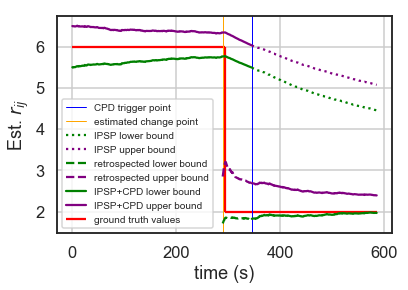

In [180]:
timer=range(0,math.ceil(w_time),1)

plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )


plt.axvline(x=the_tp_time, linestyle='-',color='b',label='CPD trigger point',linewidth=1)
plt.axvline(x=est_x, linestyle='-',color='orange',label='estimated change point',linewidth=1)


plt.plot(IPSP_est_lower[:math.ceil(the_tp_time)],linestyle='-',color='green')
plt.plot(IPSP_est_upper[:math.ceil(the_tp_time)] ,linestyle='-',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_est_lower[math.ceil(the_tp_time):],linestyle='dotted',color='green',label='IPSP lower bound')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_est_upper[math.ceil(the_tp_time):],linestyle='dotted',color='purple',label='IPSP upper bound')

#print(est_x_index,the_tp_index)
#print(len(IPSP_est_lower))

plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],new_IPSP_est_lower[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected lower bound', linestyle='dashed',color='green')
plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],new_IPSP_est_upper[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected upper bound', linestyle='dashed',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],new_IPSP_est_lower[math.ceil(the_tp_time):],label='IPSP+CPD lower bound', linestyle='-',color='green')
plt.plot(timer[math.ceil(the_tp_time):],new_IPSP_est_upper[math.ceil(the_tp_time):],label='IPSP+CPD upper bound', linestyle='-',color='purple')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=10)
plt.xlabel('time (s)')
plt.ylabel('Est. $r_{ij}$')
plt.grid(True)

plt.show()


In [184]:
# Now write the results into CSV files
#import pandas as pd

temp = np.asarray([ IPSP_est_lower,IPSP_est_upper])

np.savetxt("iCPD_UNDERSEA_java_project\IPSP_est_r_every_1_second.csv",temp.T,delimiter=',')# There is a .T means transpose the 2d array

temp = np.asarray([ new_IPSP_est_lower,new_IPSP_est_upper])

np.savetxt("iCPD_UNDERSEA_java_project\iCPD_est_r_every_1_second.csv",temp.T,delimiter=',')

In [185]:
#Now read from the verification results done in the Java project...
from numpy import genfromtxt

iCPD_PMC = genfromtxt('iCPD_UNDERSEA_java_project\iCPD_est_r_every_1_second_verification_results.csv', delimiter=',')
IPSP_PMC = genfromtxt('iCPD_UNDERSEA_java_project\IPSP_est_r_every_1_second_verification_results.csv', delimiter=',')

In [186]:
IPSP_PMC_R1_lower=IPSP_PMC.T[0] #R1 is the property 1, R2 is the property 2
IPSP_PMC_R1_upper=IPSP_PMC.T[1]
IPSP_PMC_R2_lower=IPSP_PMC.T[2]
IPSP_PMC_R2_upper=IPSP_PMC.T[3]


iCPD_PMC_R1_lower=iCPD_PMC.T[0]
iCPD_PMC_R1_upper=iCPD_PMC.T[1]
iCPD_PMC_R2_lower=iCPD_PMC.T[2]
iCPD_PMC_R2_upper=iCPD_PMC.T[3]

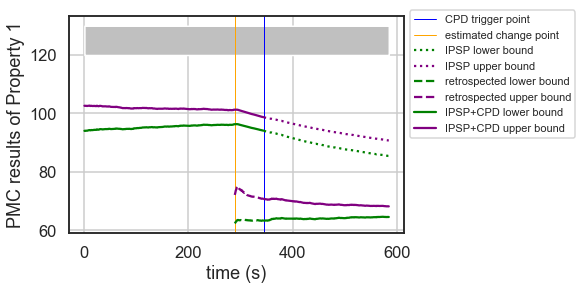

In [211]:
timer=range(0,math.ceil(w_time),1)

'''plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )
'''

plt.axvline(x=the_tp_time, linestyle='-',color='b',label='CPD trigger point',linewidth=1)
plt.axvline(x=est_x, linestyle='-',color='orange',label='estimated change point',linewidth=1)


plt.plot(IPSP_PMC_R1_lower[:math.ceil(the_tp_time)],linestyle='-',color='green')
plt.plot(IPSP_PMC_R1_upper[:math.ceil(the_tp_time)] ,linestyle='-',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_PMC_R1_lower[math.ceil(the_tp_time):],linestyle='dotted',color='green',label='IPSP lower bound')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_PMC_R1_upper[math.ceil(the_tp_time):],linestyle='dotted',color='purple',label='IPSP upper bound')

#print(est_x_index,the_tp_index)
#print(len(IPSP_est_lower))

plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],iCPD_PMC_R1_lower[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected lower bound', linestyle='dashed',color='green')
plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],iCPD_PMC_R1_upper[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected upper bound', linestyle='dashed',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],iCPD_PMC_R1_lower[math.ceil(the_tp_time):],label='IPSP+CPD lower bound', linestyle='-',color='green')
plt.plot(timer[math.ceil(the_tp_time):],iCPD_PMC_R1_upper[math.ceil(the_tp_time):],label='IPSP+CPD upper bound', linestyle='-',color='purple')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=11,bbox_to_anchor=(1, 1.05))
plt.xlabel('time (s)')
plt.ylabel('PMC results of Property 1')
plt.fill_between(timer,120,130, facecolor='Silver')
plt.grid(True)

plt.show()


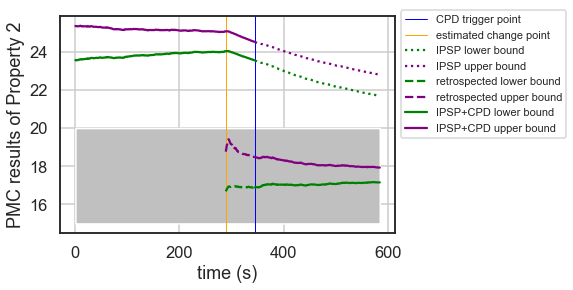

In [213]:
timer=range(0,math.ceil(w_time),1)

'''plt.hlines(y=the_a,xmin=0,xmax=the_cp_time,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp_time,xmax=w_time,
           color='r',linestyle='-' )
plt.vlines(x=the_cp_time,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )
'''

plt.axvline(x=the_tp_time, linestyle='-',color='b',label='CPD trigger point',linewidth=1)
plt.axvline(x=est_x, linestyle='-',color='orange',label='estimated change point',linewidth=1)


plt.plot(IPSP_PMC_R2_lower[:math.ceil(the_tp_time)],linestyle='-',color='green')
plt.plot(IPSP_PMC_R2_upper[:math.ceil(the_tp_time)] ,linestyle='-',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_PMC_R2_lower[math.ceil(the_tp_time):],linestyle='dotted',color='green',label='IPSP lower bound')
plt.plot(timer[math.ceil(the_tp_time):],IPSP_PMC_R2_upper[math.ceil(the_tp_time):],linestyle='dotted',color='purple',label='IPSP upper bound')

#print(est_x_index,the_tp_index)
#print(len(IPSP_est_lower))

plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],iCPD_PMC_R2_lower[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected lower bound', linestyle='dashed',color='green')
plt.plot(timer[math.ceil(est_x):math.ceil(the_tp_time)],iCPD_PMC_R2_upper[math.ceil(est_x):math.ceil(the_tp_time)],label='retrospected upper bound', linestyle='dashed',color='purple')
plt.plot(timer[math.ceil(the_tp_time):],iCPD_PMC_R2_lower[math.ceil(the_tp_time):],label='IPSP+CPD lower bound', linestyle='-',color='green')
plt.plot(timer[math.ceil(the_tp_time):],iCPD_PMC_R2_upper[math.ceil(the_tp_time):],label='IPSP+CPD upper bound', linestyle='-',color='purple')

#plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(fontsize=11,bbox_to_anchor=(1, 1.05))
plt.xlabel('time (s)')
plt.ylabel('PMC results of Property 2')
plt.fill_between(timer,15,20, facecolor='Silver')
plt.grid(True)

plt.show()
